# PCA Bootstrapped OLS Regression

Here is what is known so far <br>
1. Trading conditioned on Citi Surprise Indices ```IndexBacktest.ipynb``` seems to work for some Citi Surprise Indices (G10, Major Economies)
2. Trading conditioned on PCs of Citi Surprise Indices ```PCARawBacktest.ipynb``` seems to underperform but still beats out their index (in terms of sharpe), from an OLS standpoint the indicator is not ideal ```PCASignOLS.ipynb``` 
3. Trading conditioned on being long the residuals of regressing the PCs of the Citi Surprise Indices ```PCAOLSBacktest.ipynb``` against the Index Returns seems to work much better (from a full sample standpoint). But from an OLS standpoint the regression shows that indicator is not ideal ```PCAOLS.ipynb```

## Bootstrap Approach

In this case since there was such good performance of the in-sample model while the indicators are poor performers (from an OLS standpoint), its important to run some tests to help understand why this occurs. Start by randomly sampling the data per each test, fitting an OLS model calculating the residuals and shorting them.

## Packages

In [1]:
import os
import sys
import math
import numpy as np
import pandas as pd
import statsmodels.api as sm

from   tqdm import tqdm
from   sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

tqdm.pandas()

In [2]:
sys.path.append(r"/Users/diegoalvarez/Desktop/research/FXCarryEconomicSurprise/root/src")
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\FXCarryCitiSurprise\root\src")
from BootstrapPCAOLS import BootstrapOLS

In [3]:
df = BootstrapOLS().get_MaxMinMedian()

## Max, Min, and Median

Originally an in-sample test was used. To loosen that restriction a bootstrapped OLS model was applied with 15% sample and 3,000 simulations applied to the rank PCA portfolios. For each rank portfolio (15) get the worst, best, and median sharpe portfolios

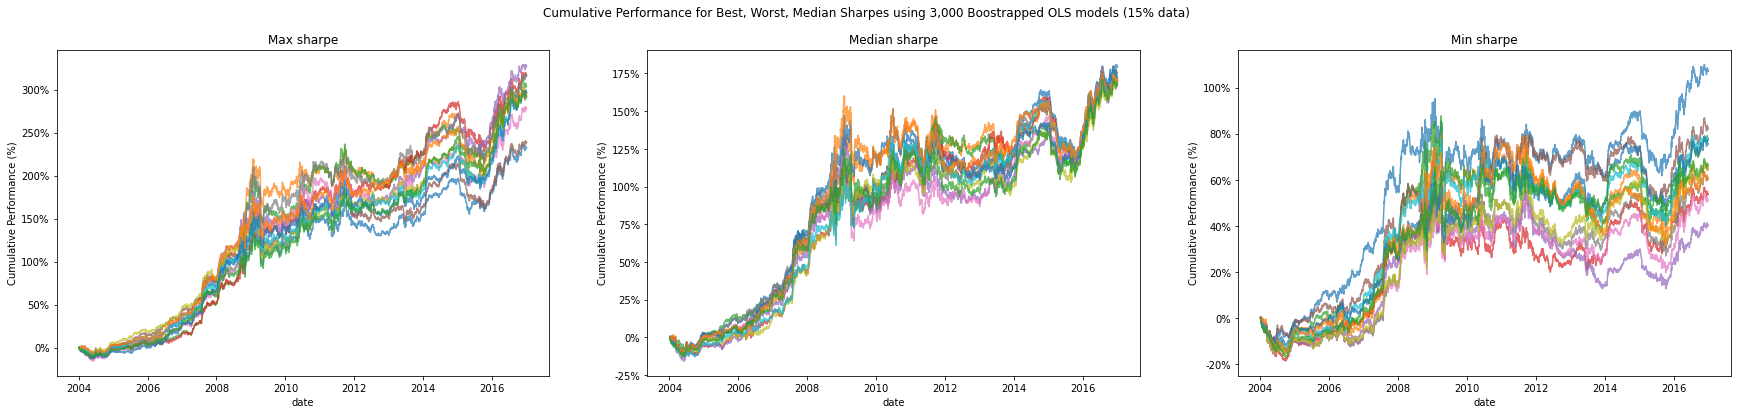

In [4]:
def plot_ports(df: pd.DataFrame) -> plt.Figure: 
    
    attributes = df.attribute.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(attributes), figsize = (30,6))

    for attribute, ax in zip(attributes, axes.flatten()):

        (df.query(
            "attribute == @attribute").
            assign(signal_rtn = lambda x: np.sign(x.lag_resid) * x.FXCARRSP).
            pivot(index = "date", columns = "model", values = "signal_rtn").
            apply(lambda x: np.cumprod(1 + x) - 1).
            plot(
                ax     = ax,
                legend = False,
                alpha  = 0.7,
                title  = attribute.replace("_", " ").capitalize(),
                ylabel = "Cumulative Performance (%)"))

        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))
        
    fig.suptitle("Cumulative Performance for Best, Worst, Median Sharpes using 3,000 Boostrapped OLS models (15% data)")
        
plot_ports(df)

In [5]:
def get_sharpe(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_sharpe = (df.assign(
        signal_rtn = lambda x: np.sign(x.lag_resid) * x.FXCARRSP)
        [["model", "signal_rtn", "attribute"]].
        groupby(["model", "attribute"]).
        agg(["mean", "std"])
        ["signal_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index())
    
    return df_sharpe

df_sharpe = get_sharpe(df)

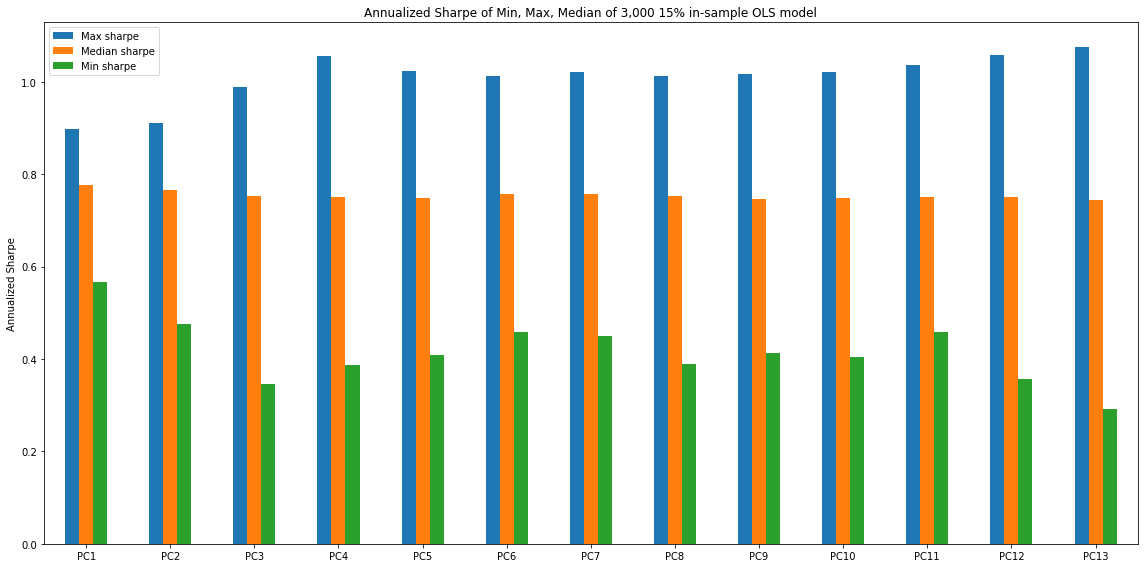

In [6]:
def plot_sharpe(df_sharpe: pd.DataFrame) -> plt.Figure: 
    
    (df_sharpe.assign(
        attribute = lambda x: x.attribute.str.replace("_", " ").str.capitalize()).
        rename(columns = {"attribute": ""}).
        pivot(index = "model", columns = "", values = "sharpe").
        reset_index().
        assign(tmp = lambda x: x.model.str.replace("PC", "").astype(int)).
        sort_values("tmp").
        set_index("model").
        drop(columns = ["tmp"]).
        plot(
            kind    = "bar",
            figsize = (16,8),
            ylabel  = "Annualized Sharpe",
            title   = "Annualized Sharpe of Min, Max, Median of 3,000 15% in-sample OLS model",
            xlabel  = "",
            rot     =  0))

    plt.tight_layout()
    
plot_sharpe(df_sharpe)

Now compare the relative performance

In [7]:
def get_spread(df: pd.DataFrame) -> pd.DataFrame: 

    df_out = (df.assign(
        signal_rtn = lambda x: np.sign(x.lag_resid) * x.FXCARRSP).
        assign(tmp = lambda x: x.model + " " + x.attribute).
        pivot(index = ["date", "FXCARRSP"], columns = "tmp", values = "signal_rtn").
        reset_index().
        melt(id_vars = ["date", "FXCARRSP"]).
        assign(
            spread    = lambda x: 0.5 * (x.value - x.FXCARRSP),
            model     = lambda x: x.tmp.str.split(" ").str[0],
            attribute = lambda x: x.tmp.str.split(" ").str[1]))
    
    return df_out

df_spread = get_spread(df)

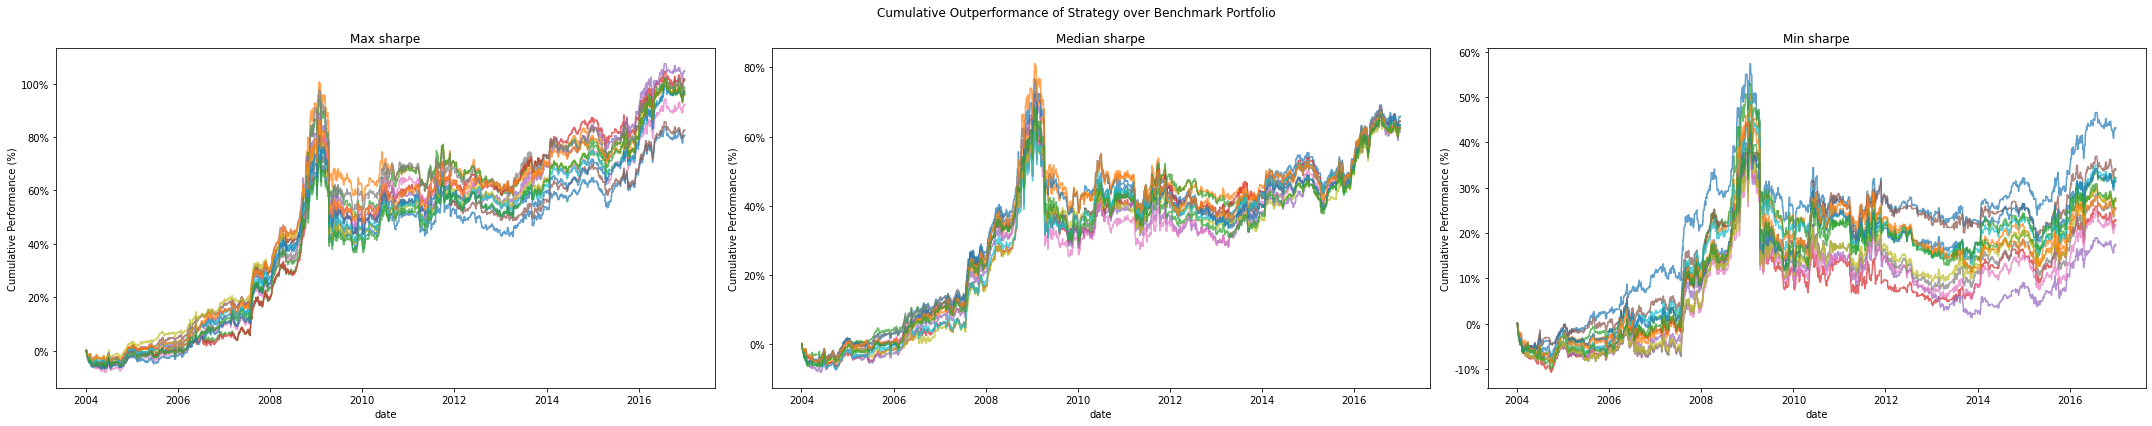

In [8]:
def plot_spread_rtn(df_spread: pd.DataFrame) -> plt.Figure: 
    
    attributes = df_spread.attribute.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(attributes), figsize = (30,6))

    for attribute, ax in zip(attributes, axes.flatten()):

        (df_spread.query(
            "attribute == @attribute").
            pivot(index = "date", columns = "model", values = "spread").
            apply(lambda x: np.cumprod(1 + x) - 1).
            plot(
                ax     = ax,
                legend = False,
                ylabel = "Cumulative Performance (%)",
                title  = attribute.replace("_", " ").capitalize(),
                alpha  = 0.7))

        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))

    fig.suptitle("Cumulative Outperformance of Strategy over Benchmark Portfolio")
    plt.tight_layout()
    
plot_spread_rtn(df_spread)

In [9]:
def get_sharpe_spread(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_sharpe_spread = (df.assign(
        tmp        = lambda x: x.model + " " + x.attribute,
        signal_rtn = lambda x: np.sign(x.lag_resid) * x.FXCARRSP).
        pivot(index = ["date", "FXCARRSP"], columns = "tmp", values = "signal_rtn").
        reset_index().
        melt(id_vars = "date").
        drop(columns = ["date"]).
        groupby("tmp").
        agg(["mean", "std"])
        ["value"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252))
        [["sharpe"]].
        T.
        melt(id_vars = "FXCARRSP").
        assign(sharpe_spread = lambda x: x.value - x.FXCARRSP))
    
    return df_sharpe_spread

df_sharpe_spread = get_sharpe_spread(df)

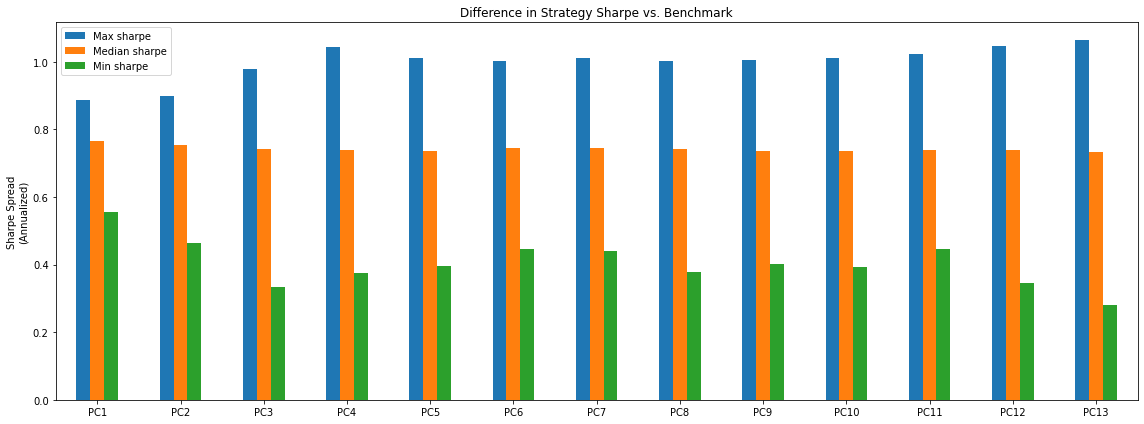

In [10]:
def plot_sharpe_spread(df_sharpe_spread: pd.DataFrame) -> plt.Figure: 
    
    (df_sharpe_spread.assign(
        model     = lambda x: x.tmp.str.split(" ").str[0],
        attribute = lambda x: x.tmp.str.split(" ").str[1].str.replace("_", " ").str.capitalize()).
        rename(columns = {"attribute": ""}).
        pivot(index = "model", columns = "", values = "sharpe_spread").
        reset_index().
        assign(tmp = lambda x: x.model.str.replace("PC", "").astype(int)).
        sort_values("tmp").
        drop(columns = ["tmp"]).
        set_index("model").
        plot(
            rot     = 0 ,
            xlabel  = "",
            ylabel  = "Sharpe Spread\n(Annualized)",
            title   = "Difference in Strategy Sharpe vs. Benchmark",
            figsize = (16,6),
            kind    = "bar"))
    
    plt.tight_layout()
    
plot_sharpe_spread(df_sharpe_spread)